In [2]:
import open3d
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import copy
import matplotlib.pyplot as plt

from time import sleep
from scipy.signal import argrelmin, argrelmax
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers
import utils.grid_search as grid_search

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
sequence = 3
    
config = Config(
    feature_dir="data/features",
    sequence_dir="data/raw_data",
    experiment="exp_10",
    trial="trial_1",
    subject="subject-1",
    sequence=f"{sequence:02d}",
    groundtruth_dir="data/trajectories/groundtruth",
    output_dir="data/trajectories/cache",
    voxel_size=0.03,
    min_std=0.5,
    target_fps=20,
    cutoff_margin=5
)

In [5]:
sequence_ts = fread.get_timstamps(config.get_feature_dir(), ext=".secondary.npz")
num_frames = len(sequence_ts)

print(f"Number of frames: {num_frames}")

Number of frames: 371


In [6]:
cache_path = f"data/trajectories/cache/{config.experiment}/{config.get_file_name()}.local.npz"
local_t = np.load(cache_path)["local_t"]

sequence_ts = np.load(cache_path)["sequence_ts"] 
num_frames = len(sequence_ts)

local_pcds = []

for t in tqdm.trange(num_frames):
    feature_file = os.path.join(config.get_feature_dir(), f"{sequence_ts[t]}.secondary.npz")
    pcd = FCGF.get_features(feature_file, pcd_only=True)
    # pcd.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    local_pcds.append(pcd)

100%|██████████| 371/371 [00:06<00:00, 56.46it/s]


In [6]:
fpfh_feats = []

for t in tqdm.trange(num_frames):
    fpfh = registration.compute_fpfh(pcd, config.voxel_size)
    fpfh_feats.append(fpfh)

100%|██████████| 371/371 [00:46<00:00,  8.06it/s]


In [ ]:
local_t = [np.identity(4)]

for t in tqdm.trange(num_frames - 1):
    ransac_reg = registration.ransac_feature_matching(local_pcds[t + 1], local_pcds[t], fpfh_feats[t + 1], fpfh_feats[t], n_ransac=4, threshold=0.05, p2p=False)
    icp_reg = registration.icp_refinement(local_pcds[t + 1], local_pcds[t], trans_init=ransac_reg.transformation, max_iteration=200, threshold=0.05, p2p=True)
    local_t.append(icp_reg.transformation)

In [7]:
std_values = []

for t in range(len(sequence_ts)):
    depth_img = Image.open(os.path.join(config.get_sequence_dir(include_secondary=True), f"frame-{sequence_ts[t]}.depth.png")).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

In [8]:
device_0_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/", config.experiment, config.trial, "global", "device-0"), ext=".depth.png")
device_1_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/", config.experiment, config.trial, "global", "device-1"), ext=".depth.png")
device_2_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/", config.experiment, config.trial, "global", "device-2"), ext=".depth.png")

y = [[], [], []]

for i in range(num_frames):
    y[0].append(helpers.nearest(device_0_ts, sequence_ts[i]))
    y[1].append(helpers.nearest(device_1_ts, sequence_ts[i]))
    y[2].append(helpers.nearest(device_2_ts, sequence_ts[i]))
    
    y[0][i] = np.abs(y[0][i] - sequence_ts[i])
    y[1][i] = np.abs(y[1][i] - sequence_ts[i])
    y[2][i] = np.abs(y[2][i] - sequence_ts[i])
    
global_frame_delays = np.array(y)
global_frame_delays_inds = np.ones(global_frame_delays.shape, dtype=np.int8)

for r, c in np.argwhere(global_frame_delays > 100):
    global_frame_delays_inds[r, c] = 0
    
global_frame_delays_inds = np.sum(global_frame_delays_inds, axis=0)
global_frame_delays_inds = np.where(global_frame_delays_inds == 3, 1, 0)

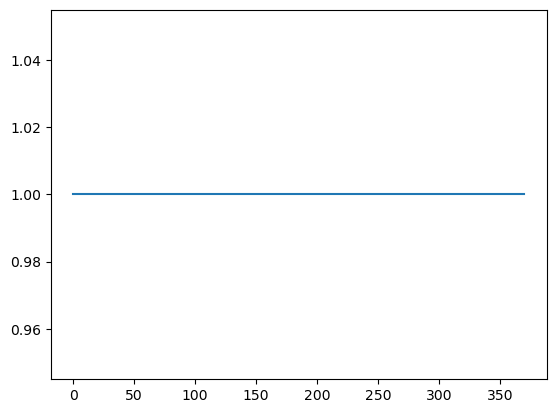

In [9]:
plt.plot(global_frame_delays_inds)

In [10]:
global_pos = [0]
for t in tqdm.trange(num_frames):
    if global_frame_delays_inds[t] == 0: continue
    
    if t - global_pos[-1] >= config.target_fps * 0.8: 
        global_pos.append(t)
        continue
    
    if (np.abs(std_values[t] - std_values[global_pos[-1]]) > config.delta) and (t - global_pos[-1] > config.target_fps * 0.5):
        global_pos.append(t)

global_pos = np.array(global_pos)

100%|██████████| 371/371 [00:00<00:00, 371381.09it/s]


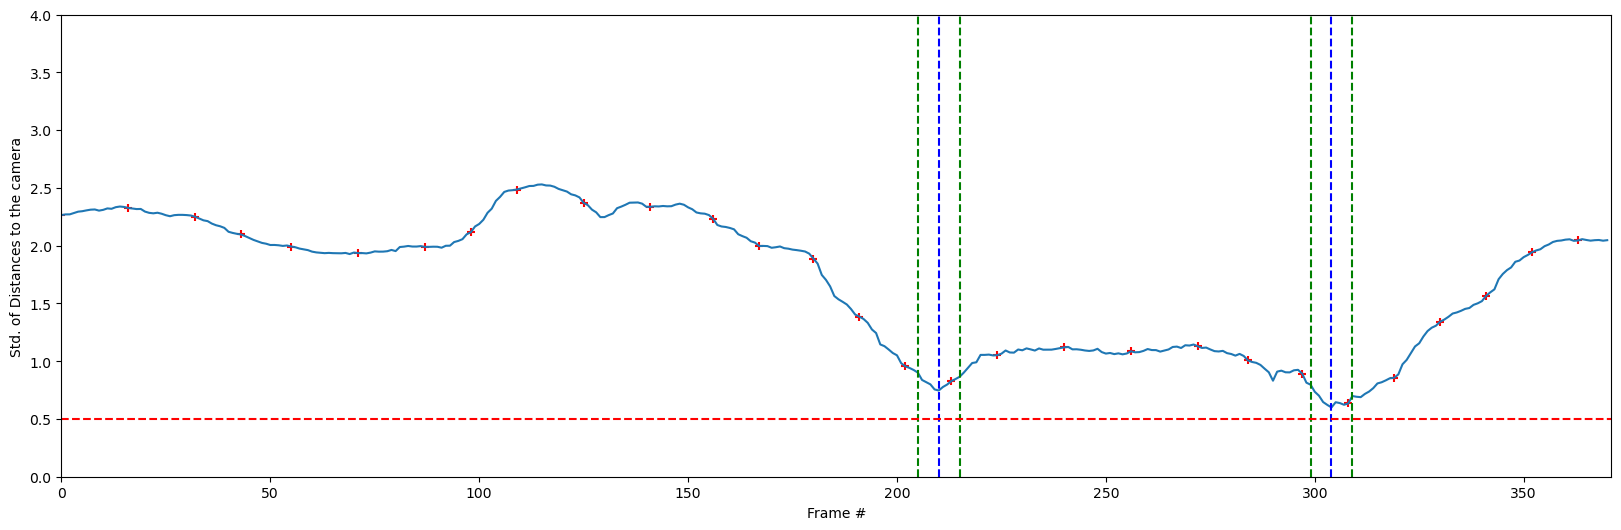

In [11]:
cutoffs = registration.find_cutoffs(std_values, config.target_fps, config.min_std)

plt.figure(figsize=(20, 6))
plt.plot(std_values)

plt.scatter(global_pos, std_values[global_pos], c="r", marker="+")

for x in cutoffs:
    plt.axvline(x - config.cutoff_margin, c="g", linestyle="--")
    plt.axvline(x, c="b", linestyle="--")
    plt.axvline(x + config.cutoff_margin, c="g", linestyle="--")
    
plt.axhline(y=config.min_std, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(std_values))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [13]:
cutoffs = registration.find_cutoffs(std_values, config.target_fps, config.min_std)
cutoffs = np.concatenate([[0], cutoffs, [num_frames - 1]])

cutoffs = [[cutoffs[i] + config.cutoff_margin, cutoffs[i + 1] - config.cutoff_margin] for i in range(len(cutoffs) - 1)]
# check if the first frame in the last cutoff is the last frame in the sequence 
cutoffs[-1][0] = min(num_frames - 1, cutoffs[-1][0])

cutoffs = [c for c in cutoffs if c[0] < c[1]]

In [14]:
trajectory_t = [np.identity(4)]

for t in range(1, num_frames):
    trajectory_t.append(np.dot(trajectory_t[t - 1], local_t[t]))
    
for i in range(len(cutoffs)):
    trajectory_pcds = []
    for t in range(cutoffs[i][0], cutoffs[i][1]):
        local_temp = copy.deepcopy(local_pcds[t])
        local_temp.transform(trajectory_t[t])
        trajectory_pcds.append(local_temp)
        
    trajectory = helpers.merge_pcds(trajectory_pcds, config.voxel_size)
    open3d.visualization.draw_geometries([trajectory])

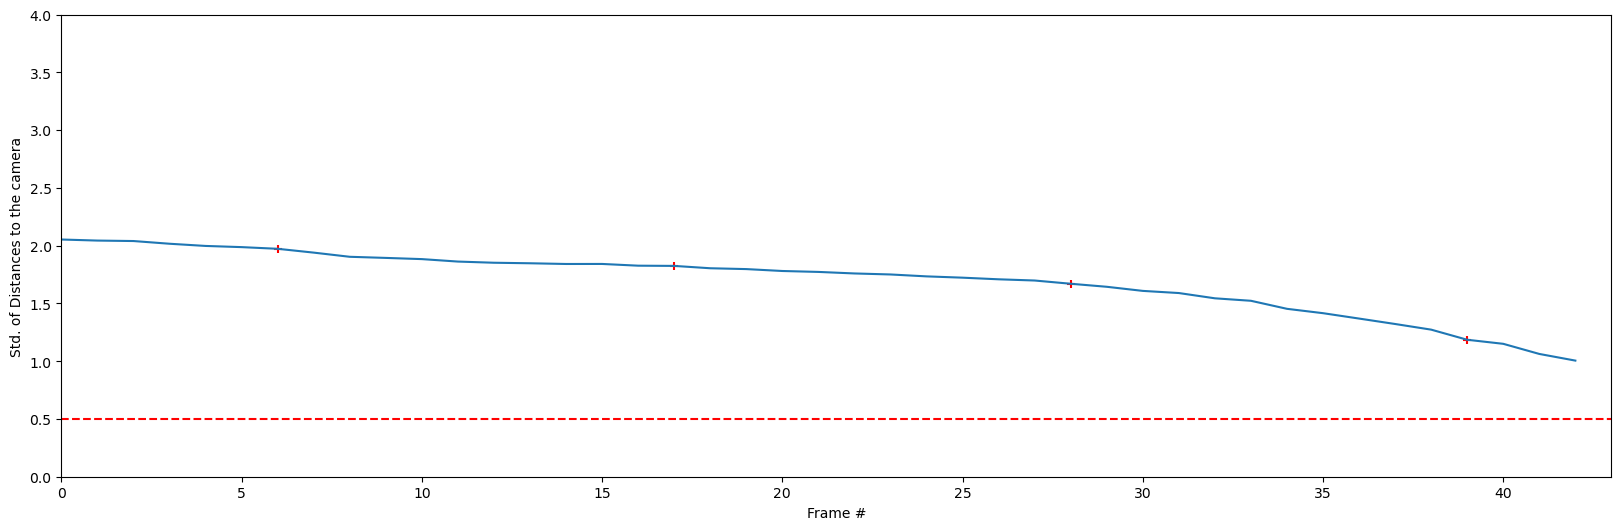

In [11]:
start_t, end_t = cutoffs[0]
window = std_values[start_t:end_t]

global_inds = global_pos[np.logical_and(global_pos >= start_t, global_pos <= end_t)] - start_t

plt.figure(figsize=(20, 6))
plt.plot(window)

plt.scatter(global_inds, window[global_inds], c="r", marker="+")

plt.axhline(y=config.min_std, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(window))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [12]:
global_t = [np.identity(4) for _ in range(num_frames)]

for start_t, end_t in cutoffs[:1]:
    global_inds = global_pos[np.logical_and(global_pos >= start_t, global_pos <= end_t)]

    global_target_t = []
    found_correct_global = False
    found_correct_global_at = -1

    for t in tqdm.trange(len(global_inds)):
        if found_correct_global:
            break
        else:
            source_feature_file = os.path.join(config.get_feature_dir(), f"{sequence_ts[global_inds[t]]}.secondary.npz")
            target_feature_file = os.path.join(config.get_feature_dir(), f"{sequence_ts[global_inds[t]]}.global.npz")
            source, target, reg_result = grid_search.global_registration(source_feature_file, target_feature_file, config.voxel_size, cell_size=2, refine_enabled=True)
            global_target_t.append(reg_result.transformation if reg_result else np.identity(4))
            # registration.describe(source, target, reg_result)
            # registration.view(source, target, reg_result.transformation if reg_result else np.identity(4))
            
        if t > 1 and not found_correct_global:
            total = 0
            for i in range(t, t - 3, -1):
                if np.sum(global_target_t[i]) == 4:
                    total += 1
                    
            if total > 1: continue
            
            try:
                global_target_t[t - 2], global_target_t[t - 1], global_target_t[t] = grid_search.validate(
                    global_target_t[t - 2], global_target_t[t - 1], global_target_t[t], 
                    helpers.merge_transformations(global_inds[t - 2], global_inds[t - 1], local_t),
                    helpers.merge_transformations(global_inds[t - 1], global_inds[t], local_t),
                    max_rot=2, max_dist=0.1
                )
                found_correct_global = True
                found_correct_global_at = t
            except Exception as e:
                print(e)
                continue
            
    if found_correct_global:
        global_t[global_inds[found_correct_global_at]] = global_target_t[found_correct_global_at]

        for t in range(global_inds[found_correct_global_at] + 1, end_t):
            global_t[t] = np.dot(global_t[t - 1], local_t[t])
            
        for t in range(global_inds[found_correct_global_at] - 1, start_t - 1, -1):
            global_t[t] = np.dot(global_t[t + 1], helpers.inv_transform(local_t[t + 1]))
                
        # else:
        #     print("     :: Finding correct point failed. Registering every frame globally.")
        #     for t in tqdm.tqdm(range(start_t, end_t)):
        #         source_feature_file = os.path.join(feature_dir, f"{sequence_ts[t]}.secondary.npz")
        #         target_feature_file = os.path.join(feature_dir, f"{sequence_ts[t]}.global.npz")
        #         source, target, reg_result = grid_search.global_registration(source_feature_file, target_feature_file, voxel_size, cell_size=3)
        #         global_t[t] = reg_result.transformation

 75%|███████▌  | 3/4 [00:35<00:11, 11.86s/it]

:: No need of correction.


In [13]:
start_t, end_t = cutoffs[0]

fragment = []

for t in range(start_t, end_t):
    local_temp = copy.deepcopy(local_pcds[t])
    local_temp.transform(global_t[t])
    fragment.append(local_temp)
    
fragment = helpers.merge_pcds(fragment, 0.03)
fragment.paint_uniform_color([0.5, 0.5, 0.5])

open3d.visualization.draw_geometries([fragment, target])

In [106]:
fragment = []

for t in range(num_frames):
    if np.sum(global_t[t]) == 4: continue
    
    local_temp = copy.deepcopy(local_pcds[t])
    local_temp.transform(global_t[t])
    fragment.append(local_temp)
    
fragment = helpers.merge_pcds(fragment, 0.03)
fragment.paint_uniform_color([0.5, 0.5, 0.5])

open3d.visualization.draw_geometries([fragment, target])